In [122]:
import pandas as pd
pd.set_option("display.max_colwidth", 1000)
pd.set_option('display.max_rows', 100)
import re
import nltk
from nltk.chunk import *
from nltk.chunk.util import *
from nltk.chunk.regexp import *
from nltk.tokenize.casual import casual_tokenize
import numpy as np
import matplotlib.pyplot as plt

## Data Collection

**Data Colection Procedure**
1. Twitter Academic Research API is applied and Twitter APIv2 is used
2. Search query is developed, after mulitple trial and errors, the following query is used:
`("Im feeling" OR "I am feeling" OR "I\'m feeling"- like) because lang:en -is:retweet`
3. Tweets are collected using the above search query and the colected time span from 2018 to Oct 2020
**Total data collected**: ~350k tweets

In [1]:

import tweepy

# Variables that contains the credentials to access Twitter API
# These token are confidential, please use your own token if you want to reproduce this

BEARER_TOKEN =  'your token'

In [272]:
import requests
import os
import json
import pandas as pd
import csv
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/all" #Change to the endpoint you want to collect data from
    
    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id,referenced_tweets.id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)


def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()
def append_to_csv(json_response, fileName, next_token):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Geolocation
        if ('geo' in tweet.keys() and 'place_id' in tweet['geo'].keys()):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 7. source
        source = tweet['source']

        # 8. Tweet text
        text = tweet['text']
        
        # 9. reply/ retweet/quote
        if 'referenced_tweets' in tweet.keys():
            tweet_type = tweet["referenced_tweets"][0]['type']
        else:
            tweet_type = 'Original'
        #10. token
        if next_token is None:
            next_token='None'
        # Assemble all data in a list
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count, tweet_type, source, text, next_token]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1
    csvFile.close()
    print("# of Tweets added from this response: ", counter) 

In [294]:
bearer_token = BEARER_TOKEN
headers = create_headers(bearer_token)
keyword = '("Im feeling" OR "I am feeling" OR "I\'m feeling"- like) because lang:en -is:retweet'

max_results = 500

#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
filename = "data_2019.csv"
csvFile = open(filename, "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','reference_type', 'source','tweet', 'next_token'])
csvFile.close()

log = []


In [296]:
year = 2019
start_list =    ['{}-{:02d}-01T00:00:00.000Z'.format(year,i) for i in range (1, 13)]

end_list =      ['{}-01-31T00:00:00.000Z'.format(year),
                 '{}-02-28T00:00:00.000Z'.format(year)] + ['{}-{:02d}-30T00:00:00.000Z'.format(year,i) for i in range(3, 13)]
for i in range(1,12):

    # Inputs
    count = 0 # Counting tweets per time period
    max_count = 50000 # Max tweets per time period
    flag = True
    next_token = None
    print ("processing start month: {}".format(i+1))
    log.append("processing start month: {}".format(i+1))
    
    # Check if flag is true
    while flag:
        # Check if max_count reached
        if count >= max_count:
            break
        log.append("next_token: {}".format(next_token))
        url = create_url(keyword, start_list[i],end_list[i], max_results)
        json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
        result_count = json_response['meta']['result_count']

        if 'next_token' not in json_response['meta']:
            flag = False
            next_token = None
        else:
            next_token = json_response['meta']['next_token']
        if result_count is not None and result_count > 0:
#                 print("Start Date: ", start_list[i])
            append_to_csv(json_response, filename, next_token)
            count += result_count
            total_tweets += result_count
            time.sleep(5)                
                    
print("Total number of results: ", total_tweets)

processing start month: 2
Endpoint Response Code: 200
# of Tweets added from this response:  490
Endpoint Response Code: 200
# of Tweets added from this response:  484
Endpoint Response Code: 200
# of Tweets added from this response:  483
Endpoint Response Code: 200
# of Tweets added from this response:  489
Endpoint Response Code: 200
# of Tweets added from this response:  490
Endpoint Response Code: 200
# of Tweets added from this response:  489
Endpoint Response Code: 200
# of Tweets added from this response:  492
Endpoint Response Code: 200
# of Tweets added from this response:  486
Endpoint Response Code: 200
# of Tweets added from this response:  489
Endpoint Response Code: 200
# of Tweets added from this response:  492
Endpoint Response Code: 200
# of Tweets added from this response:  469
processing start month: 3
Endpoint Response Code: 200
# of Tweets added from this response:  490
Endpoint Response Code: 200
# of Tweets added from this response:  489
Endpoint Response Code: 2

## Data Cleaning and Preprocessing
### Part I: Emotion Label segmentation
* Collected data is the cleaned by:
    1. stripping out reference (@), hashtag, emojis
    2. replacing `i'm, I'm, Im, im feeling` by `i am feeling` to find emotion label easier 
* List of emotion words are collected on [this] and saved as emotion_data.csv. 
* Since not all tweet that follows pattern "I'm feeling" will contains an emotional expression,`e.g. I'm feeling this is gonna get worse` , tweets are passed into a segmentation code to identify tweets that actually contain emotional expressions. 
To make sure the emotion word appear in a tweet is actually in the 'I'm feeling' phrase, emotion words must be found in the vacinity of 6 words from the position of the word "feeling"
To avoid missing out tweets without emotion words in the emotion word list, grammar structrues of tweets are explored. Tweets are tokenized and tagged with Parts of Speech (POS). A popular pattern found is that, in a typical "I am feeling X because of Y" statement, feeling will have `VBG` tag (verb gerund) and X will have `JJ` (adjective) or `VBD` (verb -ed) tag. Therefore, in tweets without emotion words, emotion_candidate are collected. These are words with `JJ` tag that is within 6 positions from the position of 'VBG'-tagged "feeling" word. Using this, I collected 31 more frequently used emotion words that were mising in the emotion word list 
* After having additional wordlist, new emotion word list is created and saved as 'emotions_updated.txt' file. Data is reprocessed to segment out emotion labels.
* **Total tweets after 1st round cleaning: ~136k**


In [2]:
more_words = ['proud', 'emotional', 'tired', 'low', 'down', 'sick', 'nostalgic', 'stressed', 'uncomfortable', 'grateful', 'sorry', 'jealous','overwhelmed', 'unmotivated', 'exhausted', 'motivated', 'sentimental']\
           + ['drained', 'unmotivated', 'hungry', 'hopeless', 'insecure', 'adventurous', 'euphoric', 'accomplished', 'nauseous', 'shitty', 'awful', 'stupid', 'horrible', 'foolish']
with open('emotions_updated.txt', 'r') as f:
    emotion_ls = f.readlines()
emotion_ls = [w.strip('\n') for w in emotion_ls]
emo_set = set(emotion_ls)
# print(emo_set[], len(emo_set))
print ('total number of emotions words : {}'.format(len(emo_set)))
print ("emotion examples: ", emo_set[:10])


In [13]:

def preprocess(tweet):
#     words = tweet.lower().split(' ')
#     words = [w for w in words if w.startswith('@') == False and w.startswith('https:') == False]
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    words = casual_tokenize(tweet.lower(), strip_handles=True)
    words = [w for w in words if isinstance(w, str) and w.startswith('https:') == False and w.startswith('#') == False ]
    res = ' '.join(words)
    return re.sub("[Ii]’*'*m feeling", "i am feeling", res)
def pos_tag(string):
    tokens = nltk.word_tokenize(string)
    tagged = nltk.pos_tag(tokens)
    return tagged

def create_clean_df(tweet_pdf):
    if 'clean_tweet' not in tweet_pdf.columns:
        tweet_pdf['clean_tweet'] = tweet_pdf['tweet'].apply(lambda x: preprocess(x) )
    if 'ID' not in tweet_pdf.columns:
        tweet_pdf['ID'] = tweet_pdf.index
    return tweet_pdf


In [119]:
def segment_emotion(tweet_pdf, emo_set):
        
    structure = {'ID':[], 'phrase': [], 'feeling_pos':[], 'emotion_phrase':[], 'emotion':[], 'emotion_pos':[], 'tweet':[], 'emotion_candidate':[]}
    tweet_pdf = tweet_pdf.query('clean_tweet == clean_tweet')
    
#     for ID, tag, tweet in zip(tweet_pdf.ID.tolist()[:],tweet_pdf.tagged_tweet.tolist()[:], tweet_pdf.clean_tweet.tolist()[:]):
    for ID, tweet in zip(tweet_pdf.ID.tolist()[:], tweet_pdf.clean_tweet.tolist()[:]):
        
        phrase_len = 6
        tag = pos_tag(tweet)
        if len(list(zip(*tag))) < 2:
            print(tweet, tag)
            print (list(zip(*tag)))
        ori_string = list(zip(*tag))[0]
        pos = list(zip(*tag))[1]
        
        count = 0
        fcount = ori_string.count("feeling")
        sindex=0 
        for i in range(fcount):
            index = ori_string.index('feeling',sindex)
            sindex=index+1
            feeling_pos = pos[index]
            if '.' in ori_string[index+1:] and ori_string.index('.', index) - index < phrase_len:
                phrase_len = ori_string.index('.', index) - index
#                 print(phrase_len, ori_string.index('.', index), tweet)
            phrase = ' '.join(ori_string[index-2:index+phrase_len])
            phrase_pos = pos[index-2:index+phrase_len]
            emotion_words = ' '.join(ori_string[index+1:index+phrase_len])
            emotions = set(ori_string[index+1:index+phrase_len]).intersection(emo_set)
            if 'kind' in emotions and emotion_words.find('kind of') != -1:
                emotions = emotions - {'kind'}
            emotion_pos = pos[index+1:index+phrase_len]

            structure['phrase'].append(phrase)
            structure['feeling_pos'].append(feeling_pos)
            structure['emotion'].append(emotions)
            structure['emotion_phrase'].append(emotion_words)
            structure['emotion_pos'].append(emotion_pos)
            structure['tweet'].append(tweet)
            structure['ID'].append(ID)

            if len(emotions) == 0:
                candidate = None
    #             print(emotion_pos, emotion_words, tweet)
                if 'JJ' in emotion_pos:
                    idx = emotion_pos.index('JJ')
                    candidate = ori_string[index+1:index+phrase_len][idx]
                elif 'VBD' in emotion_pos:
                    idx = emotion_pos.index('VBD')
                    candidate = ori_string[index+1:index+phrase_len][idx]
                structure['emotion_candidate'].append(candidate)
            else: 
                structure['emotion_candidate'].append('N/A')
        df_str = pd.DataFrame(structure)
#         df_str['feeling_phrase'] = df_str.apply(lambda x:  'i am feeling ' + ' and '.join(list(x.emotion)) if x.tweet.find("i am feeling") != -1 else None, axis=1)
#         df_str['feeling_phrase'] = df_str[['tweet', 'emotion']].apply(lambda x,y:  'i am feeling ' + ' and '.join(list(y)) if x.find("i am feeling") != -1 else None)
        df_str['num_emo'] = df_str['emotion'].apply(lambda x: len(x))
    return df_str

def find_emotion_frequency(pdf_str):
    pdf_str[pdf_str["num_emo"] > 0][['emotion', 'emotion_pos', 'phrase', 'tweet']]
    detected_emotions = pdf_str[pdf_str["emotion"]!= set({})]['emotion'].tolist()
    detected_emotions = list(map (lambda x: list(x), detected_emotions))
    all_emotions = []
    for emo in detected_emotions:
        all_emotions += emo
    return pd.DataFrame({'emotions':all_emotions})

**Code that create clean tweets and emotion labels**

In [ ]:
# Create list of cleaned tweets and then segment emotion label
df_ls =['data_{}.csv'.format(2019+i) for i in range(4) ]
res_list = []
tweet_list = []
for i,filename in enumerate(df_ls):
    print (filename)
    df = pd.read_csv(filename)
    pdf_tweet  = create_clean_df(df)
    pdf_tweet.to_csv('clean_data_{}.csv'.format(2019+i))
    tweet_list.append(pdf_tweet)

df_ls =['clean_data_{}.csv'.format(2019+i) for i in range(4) ]
print(df_ls)


res_list = []    
for i,filename in enumerate(df_ls):
    print (filename)
    df = pd.read_csv(filename)
    print(len(df))
    label_df  = segment_emotion(df, emo_set)
    label_df['year'] = 2019+i
    label_df.to_csv("label_{}.csv".format(2019+i))
    res_list.append(label_df)

data = pd.concat(res_list)
data.query('num_emo > 0').to_csv("data_with_label_v2.csv", index_label=False)


In [124]:
test = pd.read_csv("data_2021.csv")[:100]
dm0, dm1 = segment_emotion(test, emo_set)

# dm0['feeling_phrase'] = dm0[['tweet', 'emotion']].apply(lambda x:  'i am feeling ' + ' and '.join(list(x.emotion)) if x.tweet.find("i am feeling") != -1 else None, axis=1)

### Part II: Emotion-cause segmentation
* After collecting emotion label, we also need to make sure the emotion cause is present in the tweet. In this stage, I use simple heuristic search to segment out emotion-cause clause:
    * tweets where `because i am feeling X` are eliminated
    * for the remaining tweet, if `tweet.find("i am feeling") < tweet.find("emotion_label") and tweet.find('because') < tweet.find('i am feeling')` then any thing between because and "i am feeling" will be made emotion cause. 
    If `tweet.find('because') > tweet.find('i am feeling')` then anthing after because till the End_of_sentence will be made emotion cause
    * tweets with emotion cause length < 5 words are eliminated
* **Total tweets after 2nd round cleaning: ~73k**

In [4]:
def find_cause(tweet, num_emo):
    if tweet.find("because i am feeling") != -1 and num_emo < 2:
        return 1
    return 0
def extract_cause(tweet, emotion):
#     words = tweet.split(' ')
    tweet = tweet + '.'
    because_count = tweet.split(' ').count("because")
    if because_count == 1:
        bidx = tweet.find('because')
        fidx = tweet.find('i am feeling')
        if bidx < fidx: 
            return tweet[bidx:fidx]
        else:
            endb = tweet.find('.', bidx)
            return tweet[bidx:endb]
    return None

In [9]:

# Post processing to extract causes and eliminate tweets with cause <= 5 words
data = pd.read_csv("data_with_label_v2.csv")
# strip remaining emojicon and hastag
data['tweet'] = data['tweet'].apply(lambda x: preprocess(x))
data['emotion'] = data['emotion'].apply(lambda x: re.sub("'", '',x.strip('\{\}')).split(' ,'))
data['feeling_phrase'] = data[['tweet', 'emotion']].apply(lambda x:  'i am feeling ' + ' and '.join(list(x.emotion)) if x.tweet.find("i am feeling") != -1 else None, axis=1)

data['no_cause'] = data.apply(lambda x: find_cause(x.tweet, x.num_emo), axis=1)
data['ID'] = data['ID'].astype(int)
data['emo'] = data['emotion'].apply(lambda x: ' '.join(x))
data['cause'] = data.apply(lambda x: extract_cause(x.tweet, x.emotion), axis=1)
data['cause_len'] = data['cause'].apply(lambda x: len(x.strip(' ').split(' ')) if x else 0)
data.drop_duplicates('tweet').query("feeling_phrase == feeling_phrase").query("cause_len > 5")[['ID', 'tweet', 'emotion', 'num_emo', 'year', 'feeling_phrase', 'no_cause', 'emo', 'cause', 'cause_len']].to_pickle('label_v4.pickle')

## Part III: Data exploration and Analysis

In [11]:
data = pd.read_pickle('label_v4.pickle').query("no_cause == 0")

In [126]:
data

,ID,tweet,emotion,num_emo,year,feeling_phrase,no_cause,emo,cause,cause_len,tweet_len,masked
3,2,"today was and still is a day where i am feeling extremely low . i care too much about how people think of me and because of this , i think over and over again that people dont like me or im a huge burden . ( 1/2 )",[low],1,2019,i am feeling low,0,low,"because of this , i think over and over again that people dont like me or im a huge burden",20,49,"today was and still is a day where i am feeling extremely bad . i care too much about how people think of me and because of this , i think over and over again that people dont like me or im a huge burden . ( 1/2 )"
5,4,"hi , the nearest wendy's to me closed , and i'm really upset about it , because wendy's is my favorite and i treat myself to it when i am feeling down in the dumps",[down],1,2019,i am feeling down,0,down,because wendy's is my favorite and i treat myself to it when,12,35,None
6,5,"anyway , today is ten years since my mum died and i am feeling sad about that and also weird because all the biggest most important things in my life now are things she didnt get to see .",[sad],1,2019,i am feeling sad,0,sad,because all the biggest most important things in my life now are things she didnt get to see,18,39,"anyway , today is ten years since my mum died and i am feeling bad about that and also weird because all the biggest most important things in my life now are things she didnt get to see ."
10,10,i made a habit of screenshotting hashtags related to bts that happened and trended on twitter and i am feeling sad because of all the memories that i will make with those screenshots,[sad],1,2019,i am feeling sad,0,sad,because of all the memories that i will make with those screenshots,12,33,i made a habit of screenshotting hashtags related to bts that happened and trended on twitter and i am feeling bad because of all the memories that i will make with those screenshots
23,23,"i am feeling a bit guilty because my dog walker asked to borrow my dogs for 2 days to do her c & g certificate . it's a weekend though , and i don't want them away and spending some of that in a kennel , even only in the daytime . she's wonderful and loves them , but they're my babies .",[guilty],1,2019,i am feeling guilty,0,guilty,because my dog walker asked to borrow my dogs for 2 days to do her c & g certificate,19,63,"i am feeling a bit bad because my dog walker asked to borrow my dogs for 2 days to do her c & g certificate . it's a weekend though , and i don't want them away and spending some of that in a kennel , even only in the daytime . she's wonderful and loves them , but they're my babies ."
...,...,...,...,...,...,...,...,...,...,...,...,...
85436,82524,"i am feeling great today , and tomorrow and for the rest of my life because i'm not the loser who can't land a shot without hacks , or who is down bad for a cheating piece of shit trash . fuck these people who are always dishonest with their communities .",[great],1,2022,i am feeling great,0,great,"because i'm not the loser who can't land a shot without hacks , or who is down bad for a cheating piece of shit trash",25,52,"i am feeling good today , and tomorrow and for the rest of my life because i'm not the loser who can't land a shot without hacks , or who is down bad for a cheating piece of shit trash . fuck these people who are always dishonest with their communities ."
85437,82525,tasty beverage in insufficient quantity and i am feeling sad because i did not do the actual grocery shopping today . tall empty glass with mostly just ice in it is lonely now .,[sad],1,2022,i am feeling sad,0,sad,because i did not do the actual grocery shopping today,10,34,tasty beverage in insufficient quantity and i am feeling bad because i did not do the actual grocery shopping today . tall empty glass with mostly just ice in it is lonely now .
85440,82528,because shes the best aunt ever and always is there to cheer me up when i am feeling down,[down],1,2022,i am fee

In [127]:
data.num_emo.value_counts()

1    68280
2     4872
3      152
5        2
4        1
Name: num_emo, dtype: int64

In [18]:
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Distribution of Emotion Cause Length'}, xlabel='cause_len'>

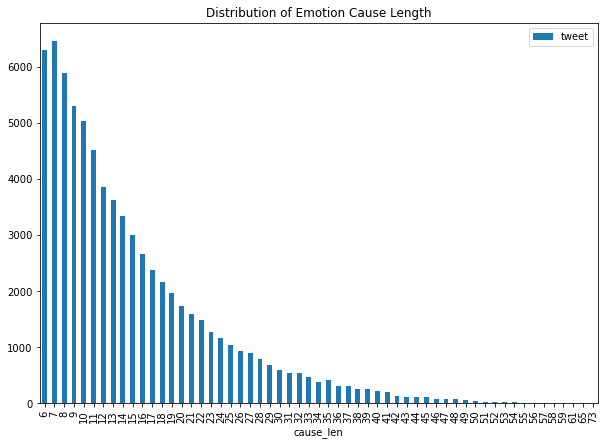

In [128]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title("Distribution of Emotion Cause Length")
data.groupby('cause_len', as_index=False).agg({'tweet':'nunique'}).plot.bar(x='cause_len', y='tweet', ax=ax)

<AxesSubplot:title={'center':'High Granularity Emotion Distribution'}, xlabel='emo'>

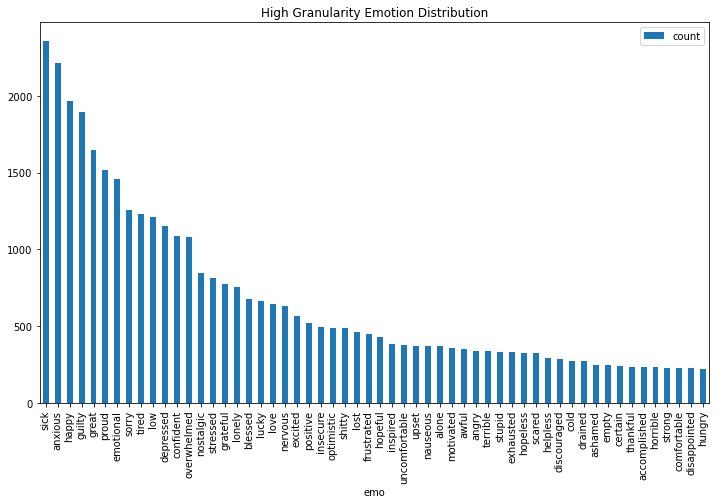

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title("High Granularity Emotion Distribution")
stats = data.query("cause_len > 5").groupby('emo').agg({'cause_len':['count'] + [np.min, np.mean, np.median, np.max ]})
stats.columns = ['count'] + ['min', 'avg', 'median', 'max']
stats.sort_values('count', ascending=False)[4:60].reset_index()[['emo', 'count']].plot.bar(x='emo', y='count',ax=ax)

In [74]:
# Top emotions in by years
stat = {}
for i in range(4):
    year = i + 2019
    top_emo = list(data.query("year == {}".format(year)).emo.value_counts().to_dict().keys())[:10]
    stat[year] = top_emo
all_time_top = list(data.emo.value_counts().to_dict().keys())[:10]
stat['all'] = all_time_top
pd.DataFrame(stat)
    

,2019,2020,2021,2022,all
0,down,down,good,good,down
1,good,sad,down,down,good
2,sad,good,sad,sad,sad
3,bad,bad,bad,bad,bad
4,sick,anxious,sick,sick,sick
5,anxious,sick,anxious,proud,anxious
6,happy,guilty,happy,anxious,happy
7,guilty,happy,guilty,happy,guilty
8,great,great,great,guilty,great
9,emotional,emotional,emotional,great,proud


In [ ]:
axes=[]
fig=plt.figure()

for a in range(rows*cols):
    b = np.random.randint(7, size=(height,width))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
fig.tight_layout()    
plt.show()

### Visualization
Word cloud visualization of emotion cause. Looks like ***love*** is the main agent behind everyone's feeling :) 

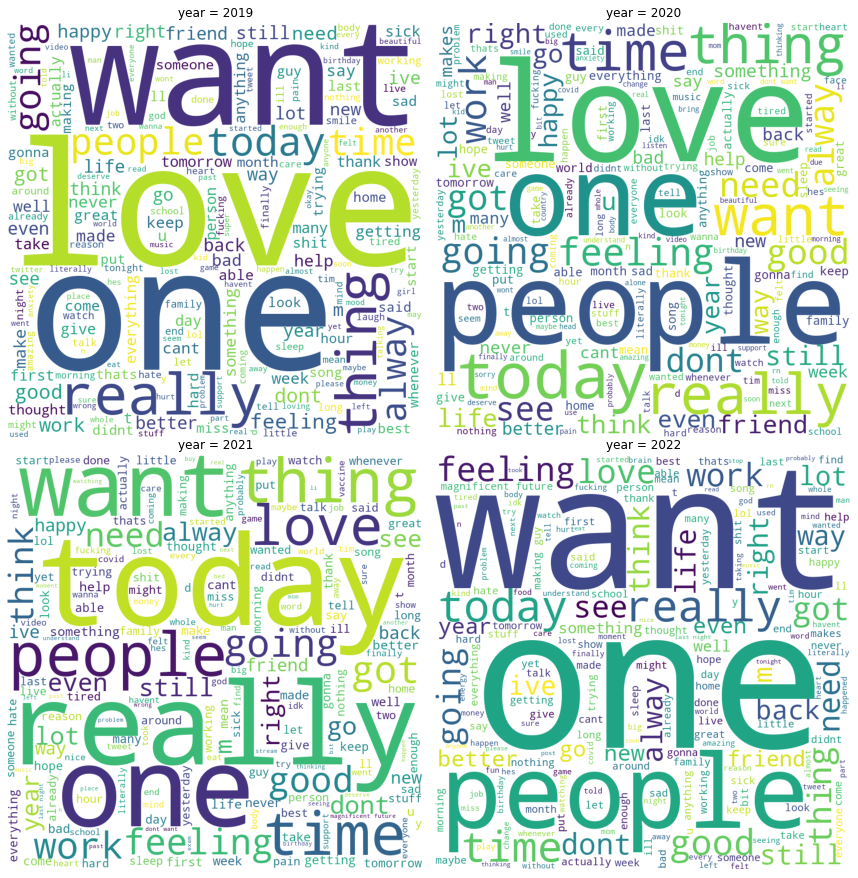

In [73]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
excluded =  ['i', 'im', 'of', 'in', 'now', 'know','day', 'make', 'much', 'feel', 'will']
axes = []
# fig = plt.figure( figsize=(20, 20))
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i in range(4):
    year = 2019 + i
    all_causes = data.query('year == {}'.format(year)).cause.tolist()
    all_causes = [w.strip('becuase|beucase of') for w in all_causes ]
    words = ' '.join(all_causes).split()
    words = [w for w in words if w not in excluded]
    all_words = ' '.join(words)
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(all_words)

    ax.ravel()[i].imshow(wordcloud)
    ax.ravel()[i].set_title("year = {}".format(year))
    ax.ravel()[i].set_axis_off()
#     plt.imshow(wordcloud)
plt.tight_layout(pad = 0)
plt.show()
 

In [243]:
data = pd.read_pickle('label_v4.pickle')
data['emo'] = data['emotion'].apply(lambda x: ' '.join(x))
data['cause'] = data.apply(lambda x: extract_cause(x.tweet, x.emotion), axis=1)
data['cause_len'] = data['cause'].apply(lambda x: len(x.strip(' ').split(' ')) if x else 0)
selected = data[~data['emo'].isin(['good', 'bad', 'sad', 'down'])].query('cause_len > 5')


### Part IV: Modeling
* Initially, the plan is to build a model that given a pair (emotion1, cause1), predict (emotion2, cause2) where emotion2 has higher granularity than emotion1 and cause2 has better details than cause 1. However, deciding what which cause have better details than the other is extremely time consuming and will also prone to subjective experience of rater. Therefore, for now, given a tweet with emotion1, the task is predict emotion2 with higher granularity that describe the context better. Observed that majority of people use "good/bad/sad/low" to describe their emotions (see stats above), I decide to mask out real emotions (with high granularity) by (good, bad). For example, if a tweet says `i am feeling proud because today i have finished a difficult task" then the masked tweet will become `i am feeling good becuase today i have finished a difficult task`. By masking out high granularity emotions with merely good and bad, I avoid subjectivity in the data labeling while having accurate label
* We can see that the data is pretty skew, so I select top 20 high granularity emotions and sample 600 tweets for each categories. In total, I create a dataset with 12000 data points and 20 categories labels. 
* The final task is formulated as follow:
> Given a tweet t in the format i am feeling `emo1` because Y + context, predict true emotion label `emo2`
The problem can be treated as a text classification problem

In [76]:
cats = {'emo':[], 'cat':[]}
emo_data = pd.read_csv('emotion.csv')
polar_map = {'open':'good', 'alive':'good', 'happy':'good', 'interested': 'good', 'positive':'good', 'strong':'good','good':'good', 'love':'good',\
             'angry':"bad", 'confused':'bad', 'helpless':'bad', 'afraid':'bad', 'hurt':'bad', 'sad':'bad', 'depressed':'bad', 'indifferent':'bad'}
for col in emo_data.columns:
    cats['emo'] += emo_data[col].dropna().tolist()
    cats['cat'] += [col] * len(emo_data[col].dropna().tolist())
    cat_pdf = pd.DataFrame(cats)
cat_pdf['masked_emo'] = cat_pdf['cat'].apply(lambda x: polar_map[x.lower()]).drop(98, axis=0)
dup_emo = cat_pdf.groupby('emo').agg({'masked_emo':'nunique'}).query('masked_emo > 1').to_dict()['masked_emo'].keys()
if len(cat_pdf[cat_pdf['emo'].isin(dup_emo)]):
    print("Warning: has duplicates!!")

masked_map = {emo:masked_emo for emo, masked_emo in zip(cat_pdf['emo'].tolist(), cat_pdf['masked_emo'].tolist())}
# masks for emotions outside polarmap
with open('additional.pickle', 'rb') as f:
    additional = pickle.load(f)
for k, v in additional.items():
    masked_map[k] = v
with open ('masked_map.pickle', 'wb') as f:
    pickle.dump(masked_map, f)

In [98]:
def create_masked_tweet(tweet, emo):
    
    eidx = tweet.find(emo)
    fidx = tweet.find("i am feeling")
    if eidx != -1 and emo in masked_map.keys():
        return tweet[:eidx] + masked_map[emo] + tweet[eidx+len(emo):]
    return None

In [102]:
selected = data[~data['emo'].isin(['good', 'bad', 'sad', 'low'])]
selected['tweet_len'] = selected.tweet.apply(lambda x: len(x.split()))
stats = selected.groupby('emo').agg({'tweet':'count'}).sort_values('tweet', ascending=False)[:50].to_dict()['tweet']

In [114]:
selected['masked'] = selected.apply(lambda x: create_masked_tweet(x.tweet, x.emo), axis=1)
selected = selected.drop_duplicates('masked')
stats = selected.groupby('emo').agg({'tweet':'count'}).sort_values('tweet', ascending=False)[:20].to_dict()['tweet']
label = pd.DataFrame()
for emo in stats.keys():
    label = label.append(selected.query("emo == '{}' and tweet_len <70".format(emo)).sample(600, random_state=18)[['masked', 'emo']] )
    
label['masked_emo'] = label['emo'].apply(lambda x: masked_map[x])
label.masked_emo.value_counts()

bad     6600
good    5400
Name: masked_emo, dtype: int64

In [115]:
label = label.sample(frac=1).reset_index(drop=True)

label.head()

,masked,emo,masked_emo
0,my idea of a good orgy is a buffet i am feeling super bad now because i just reminded myself that none are open . dammit .,depressed,bad
1,idk if its because im sick or what but i am feeling extra extra extra bad today,depressed,bad
2,"typically i trade on an empty stomach , because being hungry . makes me hungry ;) however , today i am feeling fat and good . thanks again for the mexican cuisine . a generous gesture , indeed ! when i make it up to ny , it wont be you picking up the tab . cheers , brother .",happy,good
3,i am feeling good in the number 3 pick for us but my heart will be broken and well likely pick at 10 because we win week 16 and 17,confident,good
4,not sure if i am feeling bad because of nerves for the rugby tomorrow or im actually getting ill .,sick,bad


In [289]:
import pickle

In [304]:
label = label.sample(frac=1).reset_index(drop=True)
label_dict = [(x, y) for x, y in zip(label.masked.tolist(), label.emo.tolist())]
# with open('label_final.pickle', 'wb') as f:
#     pickle.dump(label_dict, f)
    

### Final label stats

In [116]:
label['tweet_len'] = label['masked'].apply(lambda x: len(x.split()))
label.groupby('emo').agg({'tweet_len':['min', 'max', 'median', 'mean', 'count']})
# stats.sort_values('count', ascending=False)[:10]

tweet_len                            
                  min max median       mean count
emo                                              
anxious            10  68   37.0  36.796667   600
blessed            10  68   37.0  37.040000   600
confident          10  67   42.0  40.671667   600
depressed          10  68   38.0  37.978333   600
emotional          11  64   37.0  37.298333   600
grateful           10  67   44.0  42.235000   600
great              10  65   37.0  36.470000   600
guilty             12  67   38.0  38.011667   600
happy              11  68   37.0  37.116667   600
lonely             11  68   38.0  39.336667   600
love                9  69   41.0  40.098333   600
lucky              10  67   35.0  35.355000   600
nervous            10  69   38.0  37.971667   600
nostalgic          11  67   35.0  36.051667   600
overwhelmed        10  68   43.0  41.350000   600
proud              10  68   34.0  37.248333   600
sick               10  67   35.0  36.046667   600
sorry              13  68   40.0  39.601667   600
stressed           11  67   39.0  38.821667   600
tired              10  69   38.0  38.803333   600